### Import liblaries

In [1]:
#liblaries for requests
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline

from scipy.stats import ttest_ind
from scipy.stats import kruskal

#liblaries for ML
import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Loading

In [2]:
URL = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv'

req = requests.get(URL)

In [3]:
def check_status_code(req):
    match req.status_code:
        case 200:
            print ('All ok')
        case 404:
            raise Exception ('Error connect')
        case _ as e:
            print (f'Unknow error: {e}')

In [4]:
check_status_code(req)

All ok


In [5]:
df = pd.read_csv(URL, sep = ',')

### EDA for data ikea

In [6]:
#загальна інформація
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694 entries, 0 to 3693
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3694 non-null   int64  
 1   item_id            3694 non-null   int64  
 2   name               3694 non-null   object 
 3   category           3694 non-null   object 
 4   price              3694 non-null   float64
 5   old_price          3694 non-null   object 
 6   sellable_online    3694 non-null   bool   
 7   link               3694 non-null   object 
 8   other_colors       3694 non-null   object 
 9   short_description  3694 non-null   object 
 10  designer           3694 non-null   object 
 11  depth              2231 non-null   float64
 12  height             2706 non-null   float64
 13  width              3105 non-null   float64
dtypes: bool(1), float64(4), int64(2), object(7)
memory usage: 378.9+ KB


In [7]:
#загальна розмірність
df.shape 

(3694, 14)

In [8]:
#рандомні 5 записів
df.sample(5)

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
1017,1017,9265920,HAVSTA,Cabinets & cupboards,2980.0,No old price,True,https://www.ikea.com/sa/en/p/havsta-storage-co...,Yes,"Storage combination w glass doors, ...",IKEA of Sweden,47.0,212.0,203.0
2386,2386,59270354,LANDSKRONA,Sofas & armchairs,5995.0,No old price,True,https://www.ikea.com/sa/en/p/landskrona-4-seat...,Yes,4-seat sofa,Tord Björklund/IKEA of Sweden,158.0,78.0,282.0
1193,1193,30449748,ANTILOP,Chairs,16.0,SR 20,True,https://www.ikea.com/sa/en/p/antilop-supportin...,No,Supporting cushion,S Edholm/L Ullenius,NaN,NaN,NaN
1046,1046,30338420,BAGGANÄS,Cabinets & cupboards,22.0,No old price,True,https://www.ikea.com/sa/en/p/bagganaes-knob-st...,Yes,"Knob, 13 mm",H Preutz/A Fredriksson,24.0,NaN,13.0
3183,3183,19297261,NORRÅKER / NORRARYD,Tables & desks,915.0,"SR 1,045",True,https://www.ikea.com/sa/en/p/norraker-norraryd...,No,"Table and 2 chairs, 74x74 cm",Nike Karlsson/J Karlsson/N Karlsson,NaN,NaN,74.0


In [9]:
df.columns

Index(['Unnamed: 0', 'item_id', 'name', 'category', 'price', 'old_price',
       'sellable_online', 'link', 'other_colors', 'short_description',
       'designer', 'depth', 'height', 'width'],
      dtype='object')

In [10]:
# Визначення ключових стовпців для перевірки дублікатів
key_columns = ['name', 'category', 'price', 'old_price', 'sellable_online']
# Перевірка на наявність дублікатів за ключовими стовпцями
df.duplicated(subset=key_columns, keep=False).sum()

827

In [11]:
df = df.drop_duplicates(subset=key_columns, keep='first')

In [12]:
df[['Unnamed: 0', 'item_id', 'price', 'old_price', 'depth', 'height', 'width']].describe()

,Unnamed: 0,item_id,price,depth,height,width
count,3232.00000,3.232000e+03,3232.000000,2005.000000,2424.000000,2753.000000
mean,1841.61479,4.863504e+07,1094.266986,55.477307,103.273927,107.373774
std,1073.72355,2.877983e+07,1387.285065,31.029139,61.819643,72.901142
min,0.00000,5.848700e+04,3.000000,1.000000,1.000000,1.000000
25%,892.75000,2.039154e+07,195.000000,38.000000,68.000000,60.000000
50%,1886.00000,4.928608e+07,550.000000,47.000000,83.000000,80.000000
75%,2752.25000,7.039466e+07,1465.750000,61.000000,129.000000,147.000000
max,3693.00000,9.993262e+07,9585.000000,257.000000,700.000000,420.000000


In [13]:
df[['name', 'category', 'sellable_online', 'link', 'other_colors', 'short_description', 'designer']].describe()

,name,category,sellable_online,link,other_colors,short_description,designer
count,3232,3232,3232,3232,3232,3232,3232
unique,607,17,2,2662,2,1629,360
top,BESTÅ,Tables & desks,True,https://www.ikea.com/sa/en/p/norraker-norraker...,No,Chair,IKEA of Sweden
freq,138,521,3206,4,1807,43,727


In [14]:
# Видалимо ці колонки,оскільки вони не несуть в собі важливої інформації
df = df.drop(['item_id', 'link', 'Unnamed: 0', 'short_description'], axis= 1)

In [15]:
# Очищення та приведення до правильного вигляду old_price
def clean_price(price):
    # Видаляємо будь-які символи, крім цифр і знака десяткового роздільника (кома або крапка)
    clean_price = re.sub(r'[^\d,.]', '', price)
    # Замінюємо кому на точку, якщо вона є
    clean_price = clean_price.replace(',', '.')

    if clean_price == '':
        return float('nan')

    return float(clean_price)

# Застосування функції колонки old_price
df['old_price'] = df['old_price'].apply(clean_price)

# Перевірка типу даних колонки old_price
print(df['old_price'].dtype)

float64


In [16]:
# Заміна пустих значень old_price - price
df['old_price'].fillna(df['price'], inplace=True)

In [17]:
df.isnull().sum()

name                  0
category              0
price                 0
old_price             0
sellable_online       0
other_colors          0
designer              0
depth              1227
height              808
width               479
dtype: int64

In [18]:
# Заповнення 'depth', 'height', 'width' медіанними значеннями
def fill_na_with_group_mean(df, group_col, target_col):
    df[target_col] = df.groupby(group_col)[target_col].transform(
        lambda x: x.fillna(x.median())
    )

columns_to_fill = ['depth', 'height', 'width']
for col in columns_to_fill:
    fill_na_with_group_mean(df, 'category', col)

In [19]:
df.isnull().sum()

name               0
category           0
price              0
old_price          0
sellable_online    0
other_colors       0
designer           0
depth              0
height             0
width              0
dtype: int64

In [20]:
def cleanDesigners(value, removeIKEA=False, emptyValue=np.nan):
    if not isinstance(value, str):
        return value
    
    if len(value)>0 and value[0].isdigit():
        return emptyValue
    
    designers = value.split("/")
    
    if removeIKEA:
        try:
            designers.remove("IKEA of Sweden")
        except:
            pass
        
    if len(designers) > 0:
        return '/'.join(sorted(designers))
    else:
        return emptyValue

In [21]:
df['designer'] = df['designer'].apply(cleanDesigners, args=(True, "IKEA of Sweden"))

In [22]:
df['other_colors'].unique()

array(['No', 'Yes'], dtype=object)

In [23]:
df['other_colors'] = df['other_colors'].str.lower()
df['other_colors'] = df['other_colors'].apply(lambda x: True if x == 'yes' else False)

In [24]:
df.head(5)

,name,category,price,old_price,sellable_online,other_colors,designer,depth,height,width
0,FREKVENS,Bar furniture,265.0,265.0,True,False,Nicholai Wiig Hansen,48.0,99.0,51.0
1,NORDVIKEN,Bar furniture,995.0,995.0,False,False,Francis Cayouette,48.0,105.0,80.0
2,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,2095.0,False,False,Francis Cayouette,48.0,102.0,49.0
3,STIG,Bar furniture,69.0,69.0,True,True,Henrik Preutz,50.0,100.0,60.0
4,NORBERG,Bar furniture,225.0,225.0,True,False,Marcus Arvonen,60.0,43.0,74.0


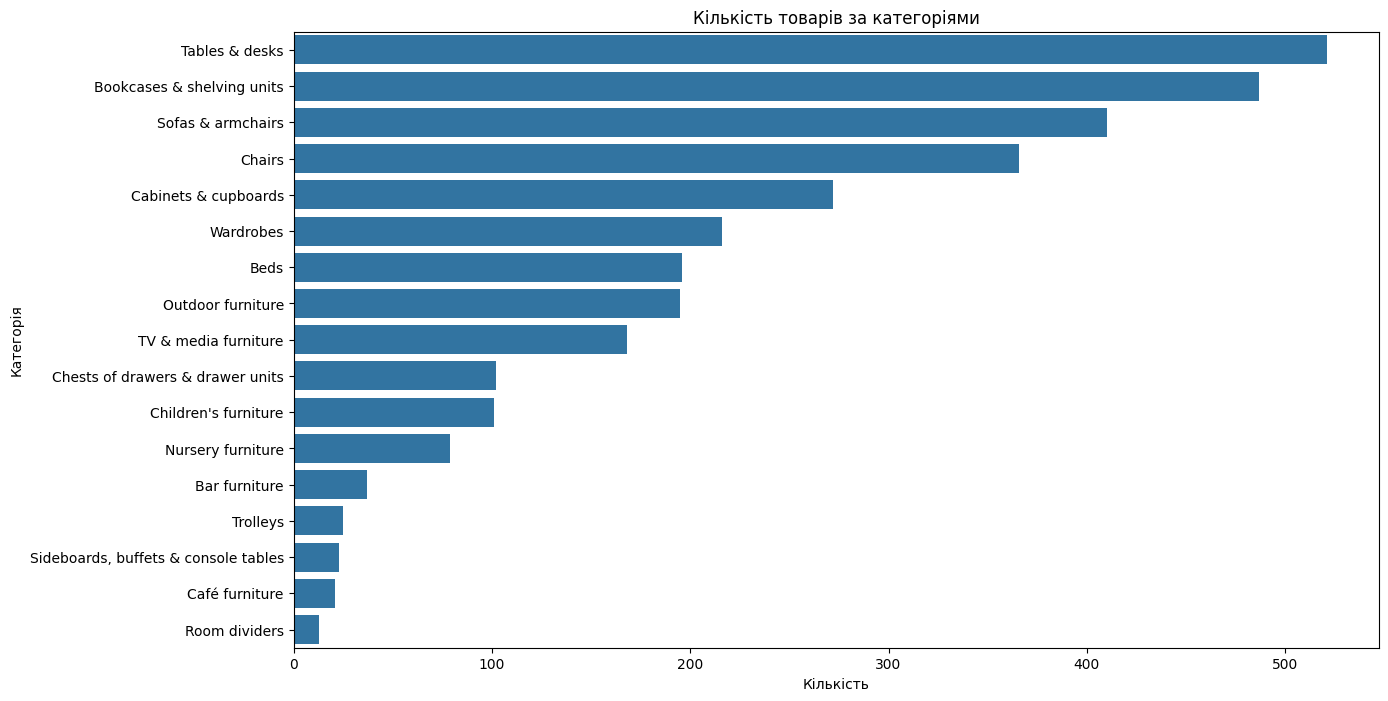

In [25]:
# Кількість товарів за категоріями
plt.figure(figsize=(14, 8))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
plt.title('Кількість товарів за категоріями')
plt.xlabel('Кількість')
plt.ylabel('Категорія')
plt.show()

Найбільші за кількістю запропонованих товарів є категорії: Tables & desks, Bookcases & shelving unit, Sofas &
armchairs, Chairs.

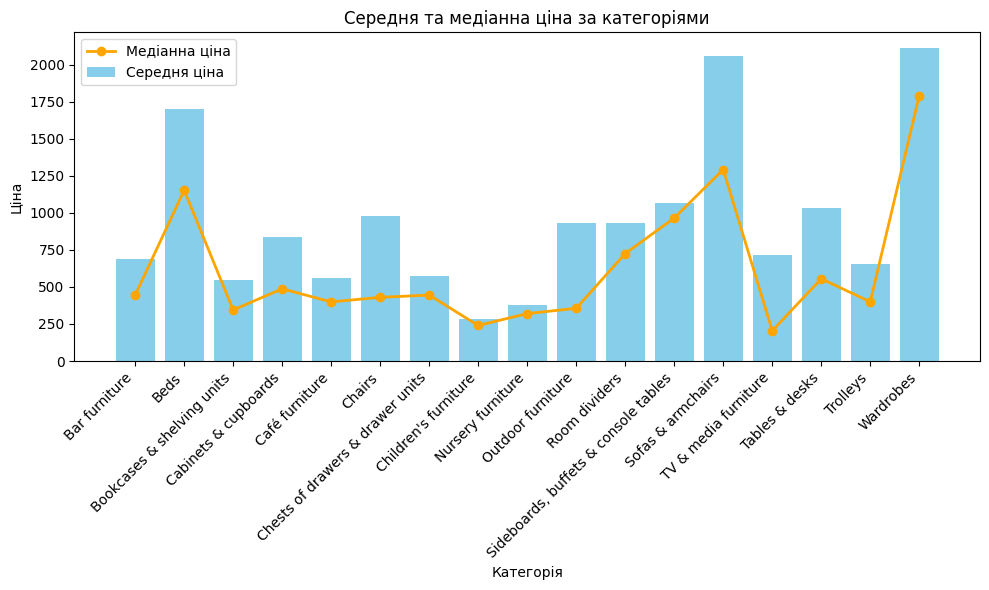

In [26]:
# Групування за категоріями та розрахунок середньої та медіанної ціни
category_prices = df.groupby('category')['price'].agg(['mean', 'median']).reset_index()

plt.figure(figsize=(10, 6))
plt.bar(category_prices['category'], category_prices['mean'], color='skyblue', label='Середня ціна')
plt.plot(category_prices['category'], category_prices['median'], marker='o', color='orange', label='Медіанна ціна', linewidth=2)
plt.xlabel('Категорія')
plt.ylabel('Ціна')
plt.title('Середня та медіанна ціна за категоріями')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

Деякі з категорій мають значну різницю між середнім та медіанним значенням. Це свідчить про те, що в цих категоріях є дуже дорогі товари, або існує помітний розподіл між бюджетними та дорогими варіантами виконання.

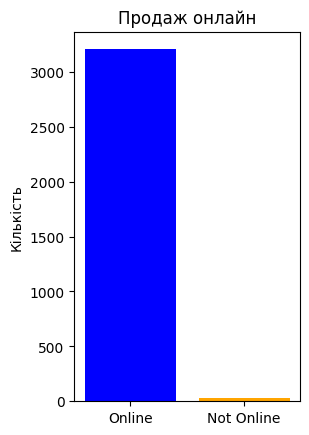

In [27]:
# Графік для типу продажу (онлайн/не онлайн)
online_sell_counts = df['sellable_online'].value_counts()

plt.subplot(1, 2, 1)
plt.bar(['Online', 'Not Online'], online_sell_counts, color=['blue', 'orange'])
plt.title('Продаж онлайн')
plt.ylabel('Кількість')
plt.show()

In [28]:
df['sellable_online'].value_counts(normalize=True) * 100

sellable_online
True     99.195545
False     0.804455
Name: proportion, dtype: float64

Майже всі товари можна придбати онлайн (99.195545%).

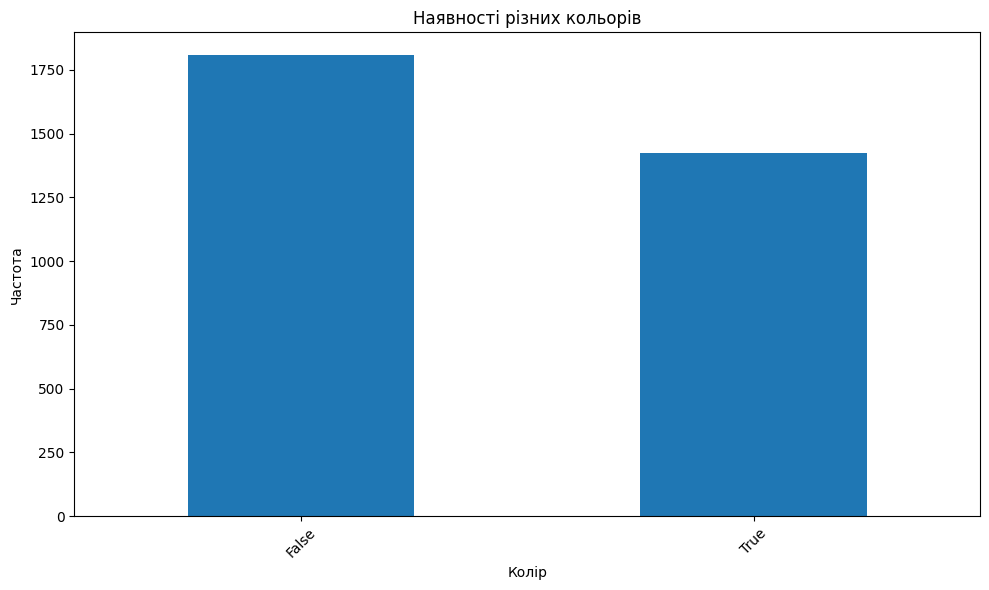

In [29]:
# Розподіл other_colors
plt.figure(figsize=(10, 6))
df['other_colors'].value_counts().plot(kind='bar')
plt.title('Наявності різних кольорів')
plt.xlabel('Колір')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
df['other_colors'].value_counts(normalize=True) * 100

other_colors
False    55.909653
True     44.090347
Name: proportion, dtype: float64

55.909653% від всіх товарів недоступні в інших кольорах.

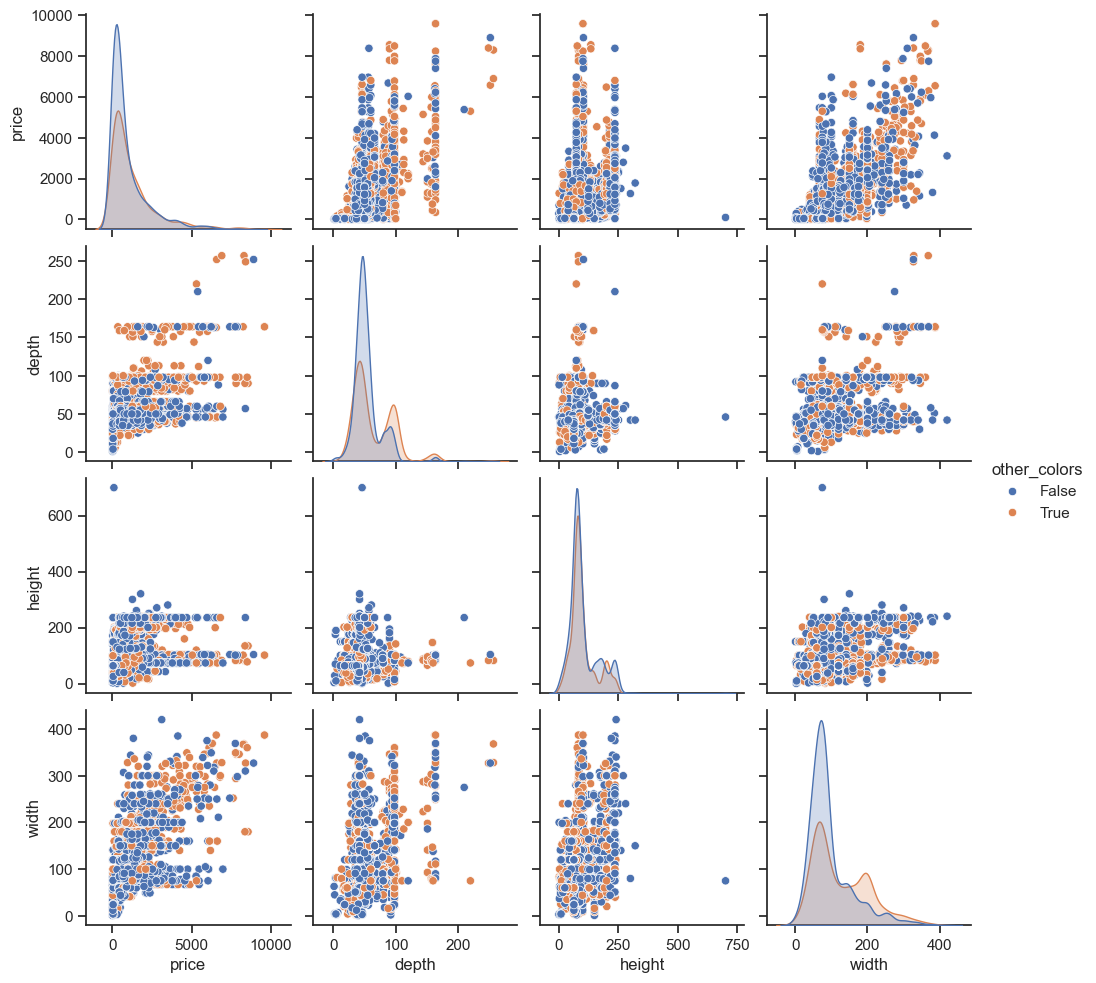

In [31]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df[['price', 'depth', 'height', 'width', 'other_colors', 'category']], hue='other_colors')
plt.show()

Цікавими параметрами для ціноутворення виявилися ширина,висота,глибина

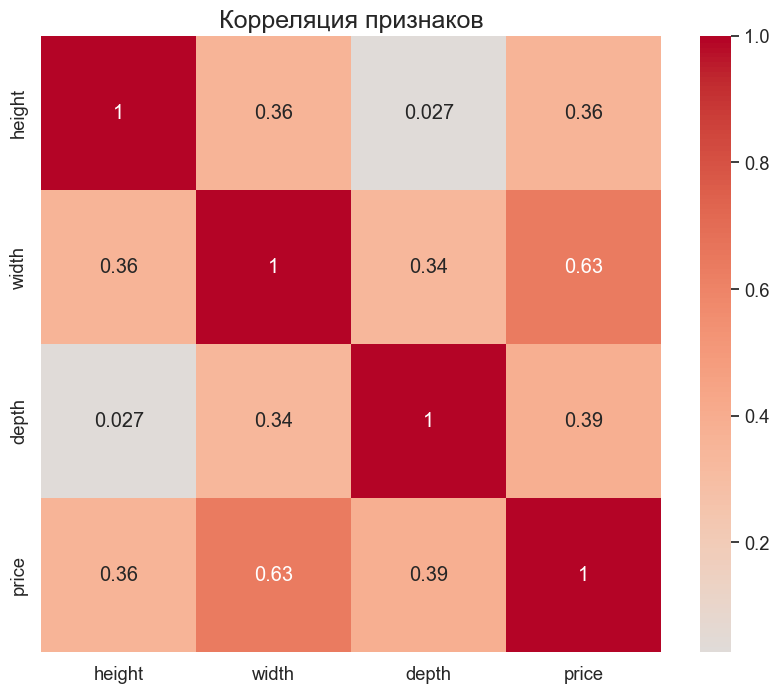

In [32]:
df_X = df[['height', 'width', 'depth', 'price']]

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
heatmap = sns.heatmap(df_X.corr(method='spearman'), 
                      xticklabels=df_X.corr().columns,
                      yticklabels=df_X.corr().columns, 
                      center=0, annot=True, cmap='coolwarm')
plt.title('Корреляция признаков', fontsize=18)
plt.show()

Теплова карта свідчить про взаємозв'язок 'price' i 'width', 'depth', 'height'

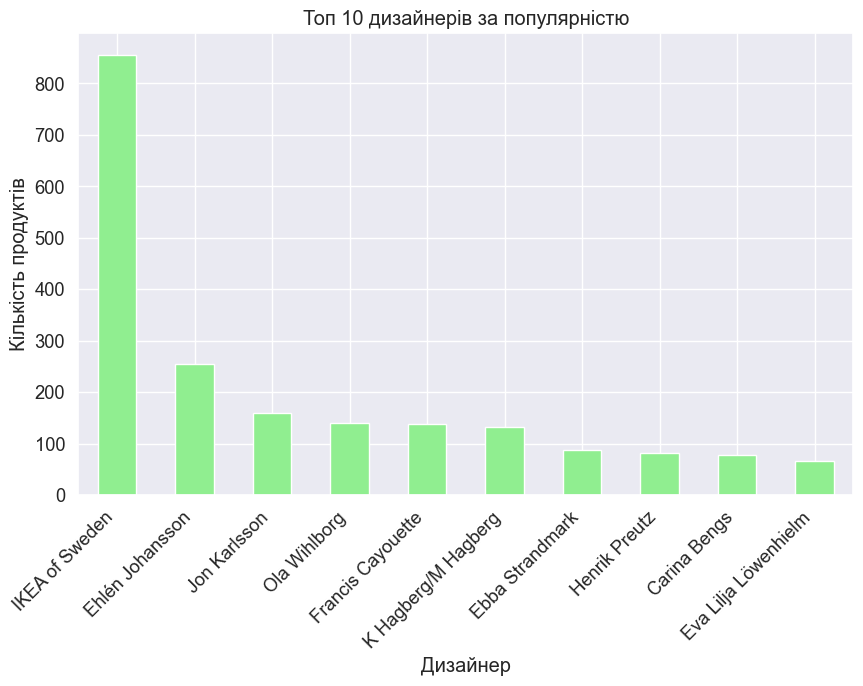

In [33]:
designer_popularity = df['designer'].value_counts().sort_values(ascending=False)[:10]

plt.figure(figsize=(10, 6))
designer_popularity.plot(kind='bar', color='lightgreen')
plt.title('Топ 10 дизайнерів за популярністю')
plt.xlabel('Дизайнер')
plt.ylabel('Кількість продуктів')
plt.xticks(rotation=45, ha='right')
plt.show()

### Гіпотези

#### Перша гіпотеза

H1: Середня ціна товарів зі знижкою відрізняється від ціни без знижки.

H0: Середня ціна товарів зі знижкою не відрізняється від ціни без знижки.

In [34]:
discounted_prices = df[(df['old_price'].notna()) & (df['old_price'] != df['price'])]['price']
regular_prices = df[(df['old_price'].isna()) | (df['old_price'] == df['price'])]['price']

ttest_result_discount = ttest_ind(discounted_prices, regular_prices)

print('t-тест: t-статистика = {:.2f}, p-значення = {:.5f}'.format(ttest_result_discount.statistic, ttest_result_discount.pvalue))

t-тест: t-статистика = 5.44, p-значення = 0.00000


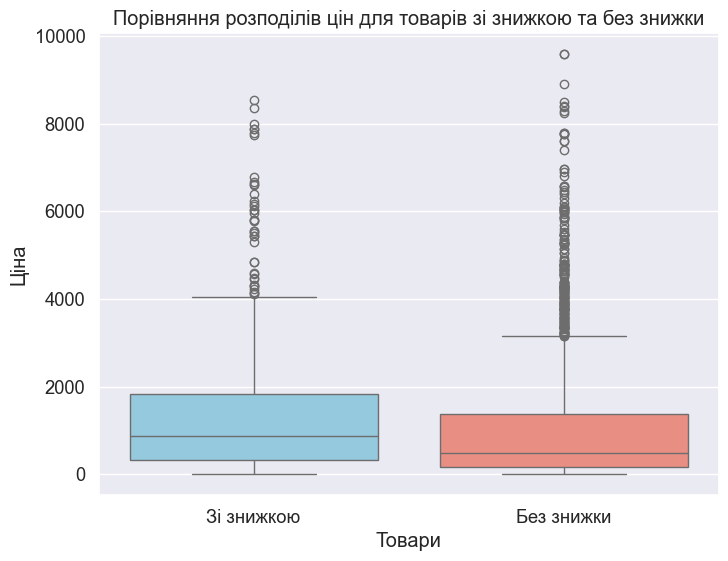

In [35]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=['Зі знижкою'] * len(discounted_prices) + ['Без знижки'] * len(regular_prices),
            y=pd.concat([discounted_prices, regular_prices]),
            palette=["skyblue", "salmon"])
plt.title('Порівняння розподілів цін для товарів зі знижкою та без знижки')
plt.xlabel('Товари')
plt.ylabel('Ціна')
plt.show()

Висновок: Ми відкидаємо нульову гіпотезу і можемо зробити висновок, що середня ціна товарів зі знижкою відрізняється від ціни товарів без знижки.

#### Друга гіпотеза

H1: Великі предмети меблів (з більшою глибиною, висотою чи шириною) мають вищу середню ціну в порівнянні з меншими предметами.

H0: Великі предмети меблів (з більшою глибиною, висотою чи шириною) мають однакову середню ціну порівняно з меншими предметами.

In [36]:
# Групування товарів за розмірами
df['size'] = df[['depth', 'height', 'width']].mean(axis=1)
df['size_category'] = pd.qcut(df['size'], 3, labels=['Small', 'Medium', 'Large'])

In [37]:
# Порівняння середніх цін між групами розмірів
size_price_means = df.groupby('size_category')['price'].mean()
print(size_price_means)

size_category
Small      361.814787
Medium     972.808465
Large     1952.947163
Name: price, dtype: float64


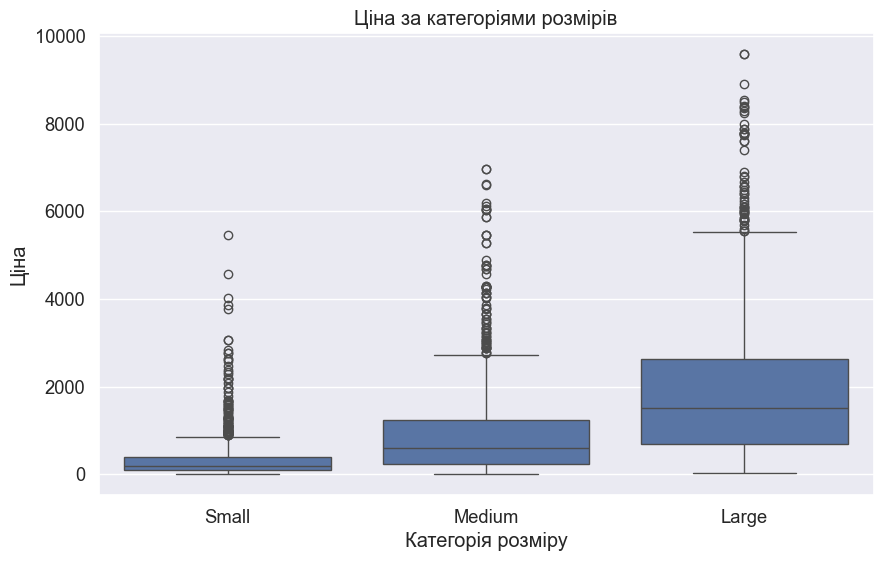

In [38]:
# Візуалізація
plt.figure(figsize=(10, 6))
sns.boxplot(x='size_category', y='price', data=df)
plt.title('Ціна за категоріями розмірів')
plt.xlabel('Категорія розміру')
plt.ylabel('Ціна')
plt.show()

In [39]:

# Тест Крускала-Уоллиса
small_prices = df[df['size_category'] == 'Small']['price']
medium_prices = df[df['size_category'] == 'Medium']['price']
large_prices = df[df['size_category'] == 'Large']['price']

kruskal_test_result = kruskal(small_prices, medium_prices, large_prices)
print('Kruskal-Wallis тест: H-статистика = {:.2f}, p-значення = {:.5f}'.format(kruskal_test_result.statistic, kruskal_test_result.pvalue))

Kruskal-Wallis тест: H-статистика = 1067.45, p-значення = 0.00000


Висновок:

H-статистика дорівнює 1067.45. Це значення свідчить про те, наскільки сильно відрізняються ранги середніх цін між групами.

p-значення дорівнює 0.00000. Це вкрай низьке значення, яке свідчить, що можливість отримати такі чи більше екстремальні різницю між групами випадково вкрай мала.

Таким чином, у нас достатньо даних, щоб відкинути нульову гіпотезу на рівні значущості 0.05. Це дозволяє зробити висновок у тому, що великі предмети меблів (з великими габаритами) мають статистично значуще вище середню ціну проти меншими предметами меблів.

### ML

In [40]:
check_status_code(req)

All ok


In [41]:
ikea_df = pd.read_csv(URL, sep = ',')

In [42]:
ikea_df = ikea_df.drop_duplicates(subset=key_columns, keep='first')

In [43]:
# designer clean
ikea_df['designer'] = ikea_df['designer'].apply(cleanDesigners, args=(True, "IKEA of Sweden"))

In [44]:
def evaluate_model(ikea_df, model):
    features = ['category', 'sellable_online', 'other_colors', 'designer', 'depth', 'height', 'width']
    target = 'price'

    X = ikea_df[features]
    y = ikea_df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    numeric_features = ['depth', 'height', 'width']
    categorical_features = ['category', 'sellable_online', 'other_colors', 'designer']

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return r2, mae, rmse

In [45]:
def compare_models(ikea_df, models):
    results = []
    
    for name, model in models:
        r2, mae, rmse = evaluate_model(ikea_df, model)
        results.append((name, r2, mae, rmse))
    
    results_df = pd.DataFrame(results, columns=['Model', 'R^2', 'MAE', 'RMSE'])
    
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    results_df.plot(x='Model', y='R^2', kind='barh', ax=axes[0], legend=False, color='b')
    axes[0].set_title('R^2 Score')
    axes[0].set_ylabel('R^2')
    
    results_df.plot(x='Model', y='MAE', kind='barh', ax=axes[1], legend=False, color='r')
    axes[1].set_title('Mean Absolute Error')
    axes[1].set_ylabel('MAE')
    
    results_df.plot(x='Model', y='RMSE', kind='barh', ax=axes[2], legend=False, color='g')
    axes[2].set_title('Root Mean Squared Error')
    axes[2].set_ylabel('RMSE')
    
    plt.tight_layout()
    plt.show()

    return results_df

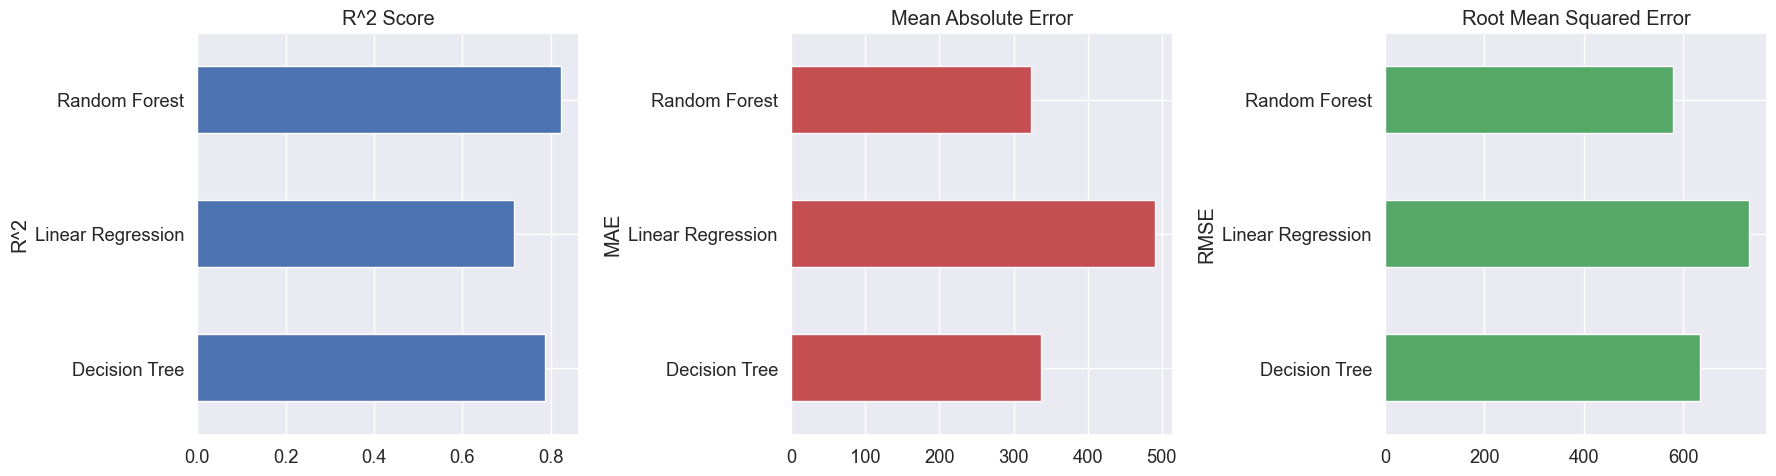

In [46]:
models = [
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(random_state=42))
]

df_models = compare_models(ikea_df, models)

In [47]:
df_models.sort_values(by='RMSE', ascending=True)

,Model,R^2,MAE,RMSE
2,Random Forest,0.822456,323.567567,579.899299
0,Decision Tree,0.787833,337.075237,633.926215
1,Linear Regression,0.717011,490.350314,732.124334


Модель RandomForestRegressor показала найкращий результат серед інших

In [48]:
# 'depth', 'height', 'width'
for col in columns_to_fill:
    fill_na_with_group_mean(ikea_df, 'category', col)

In [49]:
# other_colors to bool
ikea_df['other_colors'] = ikea_df['other_colors'].str.lower()
ikea_df['other_colors'] = ikea_df['other_colors'].apply(lambda x: True if x == 'yes' else False)

In [50]:
features = ['depth', 'height', 'width']
target = 'price'

X = ikea_df[features]
y = ikea_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
param_grid = {'n_estimators': [10, 20, 30, 50],
              'max_depth': [None, 5, 10, 20],
              'max_features': ['auto', 'sqrt', 'log2']
              }

rfr_grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, n_jobs=-1, verbose=0)

rfr_grid.fit(X_train, y_train)

y_pred = rfr_grid.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
 
print('Best Estimator :',rfr_grid.best_estimator_)
print('Best Score     :',rfr_grid.best_score_)
print('')
print('R^2            : {:.5f}'.format(r2))
print('MAE            : {:.5f}'.format(mae))
print('RMSE           : {:.5f}'.format(rmse))
print('')
print('Feature importance:')
print('--------------------------------')

for feat, importance in zip(X_train.columns, rfr_grid.best_estimator_.feature_importances_):
    print('{:.5f}    {f}'.format(importance, f=feat))

Best Estimator : RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=50)
Best Score     : 0.7667848739869809

R^2            : 0.77599
MAE            : 370.04233
RMSE           : 651.38122

Feature importance:
--------------------------------
0.23326    depth
0.20667    height
0.56006    width


/Users/yuriihuzhva/Desktop/IT/Learning/dan.it/Python/Step_project_python_yg/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
80 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
66 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yuriihuzhva/Desktop/IT/Learning/dan.it/Python/Step_project_python_yg/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yuriihuzhva/Desktop/IT/Learning/dan.it/Python/Step_project_python_yg/venv/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._va

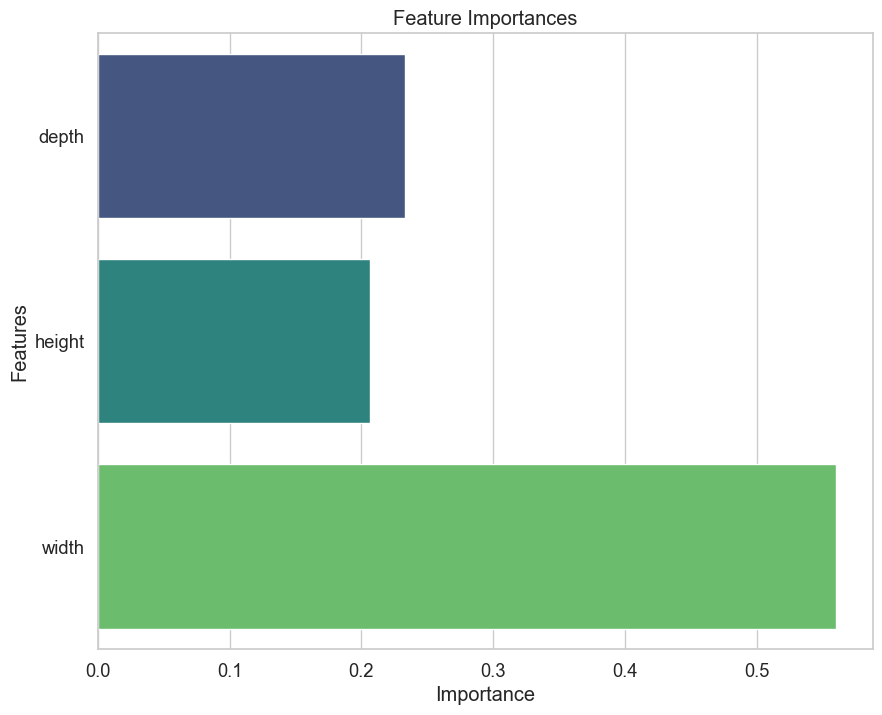

In [52]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 8))
sns.barplot(y=X_train.columns, x=rfr_grid.best_estimator_.feature_importances_, palette="viridis")
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

Проаналізувавши дані з датафрейму ikea,отримали, що найбільш впливовими колонками для формування цін є: 'width', 'depth', 'height'. 

При цьому значення вагових  коефіцієнтів таке:

для depth - 0.23326

для height - 0.20667

для width - 0.56006

Використали такі регресійні моделі: DecisionTreeRegressor, RandomForestRegressor, LinearRegression.

Найкращою моделлю виявилась RandomForestRegressor.

Найкращий параметр для глибини дерева (max_depth) - 20

Кількість ознак для кожного розбиття (max_features) - 'sqrt'

Кількість дерев - 50

Best Score: 0.7667848739869809

R^2(коефіцієнт детермінації) = 0.77599. Він вказує, який відсоток мінливості залежної змінної може бути пояснений з використанням предикторів.

MAE = 370.04233 вимірює середню абсолютну помилку між фактичними значеннями та передбаченими значеннями моделі.

RMSE(Root Mean Squared Error) = 651.38122 є середньоквадратичною похибкою між прогнозованими і фактичними значеннями.

In [57]:
rfr = RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=50)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(rfr, X_train, y_train, cv=cv)

mean_score = np.mean(cv_scores)

print("Cross-validated scores:", cv_scores)
print("Mean CV score:", mean_score)


Cross-validated scores: [0.77141849 0.81361424 0.77448487 0.73077631 0.70748286]
Mean CV score: 0.7595553566742372


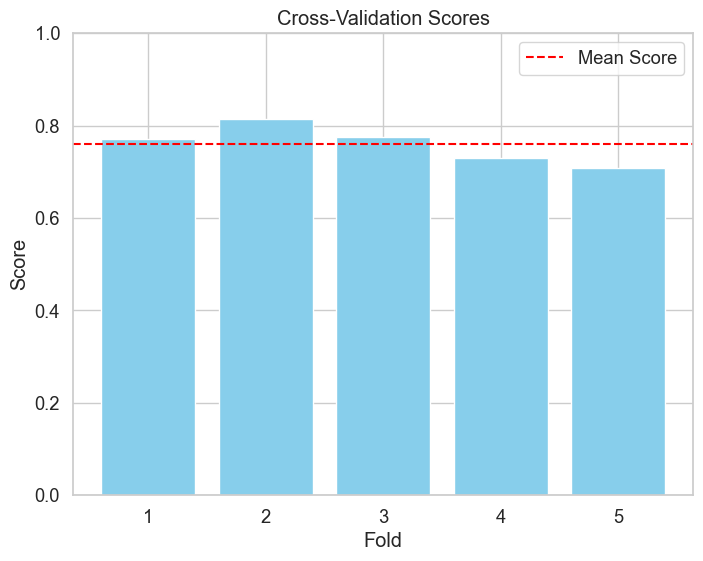

In [58]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(cv_scores)+1), cv_scores, color='skyblue')
plt.axhline(mean_score, color='red', linestyle='--', label='Mean Score')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Cross-Validation Scores')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [55]:
parameters = {
    'max_depth': [10,30,50,70,100,150,180,200,None], 
    'max_features': ['auto','sqrt','log2']
}

dtf = DecisionTreeRegressor()

dtr_grid = GridSearchCV(dtf, parameters, cv = 5, n_jobs= -1, verbose=0)
dtr_grid.fit(X_train, y_train)

print("Best Parameters: ", dtr_grid.best_params_)
print("Best Score: ", dtr_grid.best_score_)


Best Parameters:  {'max_depth': 200, 'max_features': 'log2'}
Best Score:  0.6974499966792913


/Users/yuriihuzhva/Desktop/IT/Learning/dan.it/Python/Step_project_python_yg/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yuriihuzhva/Desktop/IT/Learning/dan.it/Python/Step_project_python_yg/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yuriihuzhva/Desktop/IT/Learning/dan.it/Python/Step_project_python_yg/venv/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._va

In [56]:
best_params = dtr_grid.best_params_

best_dtr = DecisionTreeRegressor(**best_params, random_state=42)

best_dtr.fit(X_train, y_train)

y_pred = best_dtr.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('R^2            : {:.5f}'.format(r2))
print('MAE            : {:.5f}'.format(mae))
print('RMSE           : {:.5f}'.format(rmse))
print('')

R^2            : 0.71154
MAE            : 395.63994
RMSE           : 739.16735

